In [1353]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter  
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler  # 추가된 부분
from sklearn.model_selection import KFold
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [1354]:
path = '/Users/iamyoungjin/Desktop/Nottingham Modules/Term1/ML/Assignment2/TrainDataset2023.xls'
df = pd.read_excel(path)
df = df.drop('ID', axis=1)

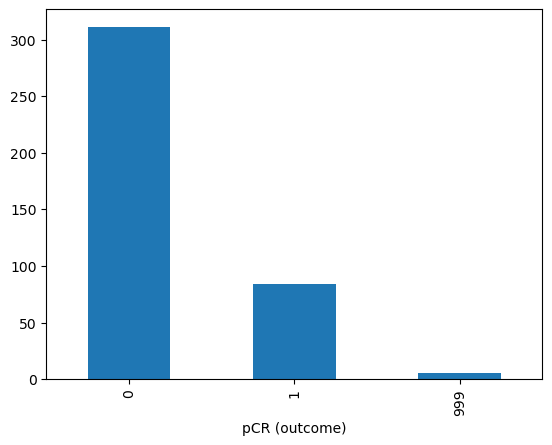

In [1355]:
df['pCR (outcome)'].value_counts().plot(kind='bar')
plt.show()

In [1356]:
# change "999" to NaN
df.replace(999, pd.NA, inplace=True)

# Finding missing value 
columns_with_missing_values = df.columns[df.isnull().any()]
print("Columns which has missing values:", columns_with_missing_values)

Columns which has missing values: Index(['pCR (outcome)', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade',
       'Proliferation', 'HistologyType', 'LNStatus'],
      dtype='object')


In [1357]:
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

for column, value in missing_data.items():
    if value != 0:
        print(f"colum:{column}, {missing_data[column]}")
        print(f"colum:{column}, {missing_percentage[column]}%")

colum:pCR (outcome), 5
colum:pCR (outcome), 1.25%
colum:PgR, 1
colum:PgR, 0.25%
colum:HER2, 1
colum:HER2, 0.25%
colum:TrippleNegative, 1
colum:TrippleNegative, 0.25%
colum:ChemoGrade, 3
colum:ChemoGrade, 0.75%
colum:Proliferation, 2
colum:Proliferation, 0.5%
colum:HistologyType, 3
colum:HistologyType, 0.75%
colum:LNStatus, 1
colum:LNStatus, 0.25%


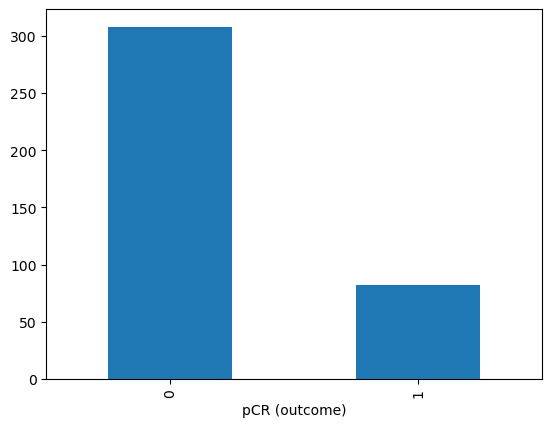

In [1358]:
missing_data = df.isnull().sum()
df = df.dropna()
df['pCR (outcome)'].value_counts().plot(kind='bar')
plt.show()

In [1359]:
pCR_label = df['pCR (outcome)'] # Classlification Label
RelapseFreeSurvival_label = df['RelapseFreeSurvival (outcome)'] # Regression Label
df = df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)

In [1360]:
columns_minmax_encode = ['Age'] + df.columns[10:].tolist()
columns_onehot_encode = df.columns[1:5].tolist() + df.columns[7:9].tolist()
columns_label_encode = df.columns[5:7].tolist() + [df.columns[9]]

# Min-Max Scaling 
scaler = MinMaxScaler()
df[columns_minmax_encode] = scaler.fit_transform(df[columns_minmax_encode])

# One-Hot Encoding
df = pd.get_dummies(df, columns=columns_onehot_encode)

# Label Encoding
label_encoder = LabelEncoder()
for col in columns_label_encode:
    df[col] = label_encoder.fit_transform(df[col])


In [1361]:
# NAN check
total_nan_cnt = df.isnull().sum().sum()
total_nan_cnt

0

In [1362]:
# 모델 생성
class MLP2(nn.Module):
    def __init__(self, input_shape, dropout=0.2):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(input_shape, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
    
class MLP1(nn.Module):
    def __init__(self, input_shape, dropout=0.3):
        super(MLP1, self).__init__()
        self.fc1 = nn.Linear(input_shape, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(32, 16)  
        self.relu3 = nn.ReLU()        
        self.dropout3 = nn.Dropout(dropout)  
        self.fc4 = nn.Linear(16, 2)  

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        return x


In [1363]:
X = df.values
y = pCR_label.values

X = X.astype(np.float32)
y = y.astype(np.int64)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

epochs = 60
lr = 0.001
input_shape = X.shape[1]
criterion = nn.CrossEntropyLoss()

acc_lst = []


for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)

    model = MLP2(input_shape)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()
        outputs = model(X_test_tensor)
        predicted = torch.argmax(outputs, dim=1)

        acc = accuracy_score(y_test_tensor, predicted)
        print(f'ACC:{acc}')
        acc_lst.append(acc)


print(f'Avg Accuracy: {np.mean(acc_lst)}')




ACC:0.8076923076923077
ACC:0.7435897435897436
ACC:0.782051282051282
ACC:0.8205128205128205
ACC:0.7948717948717948
Avg Accuracy: 0.7897435897435898


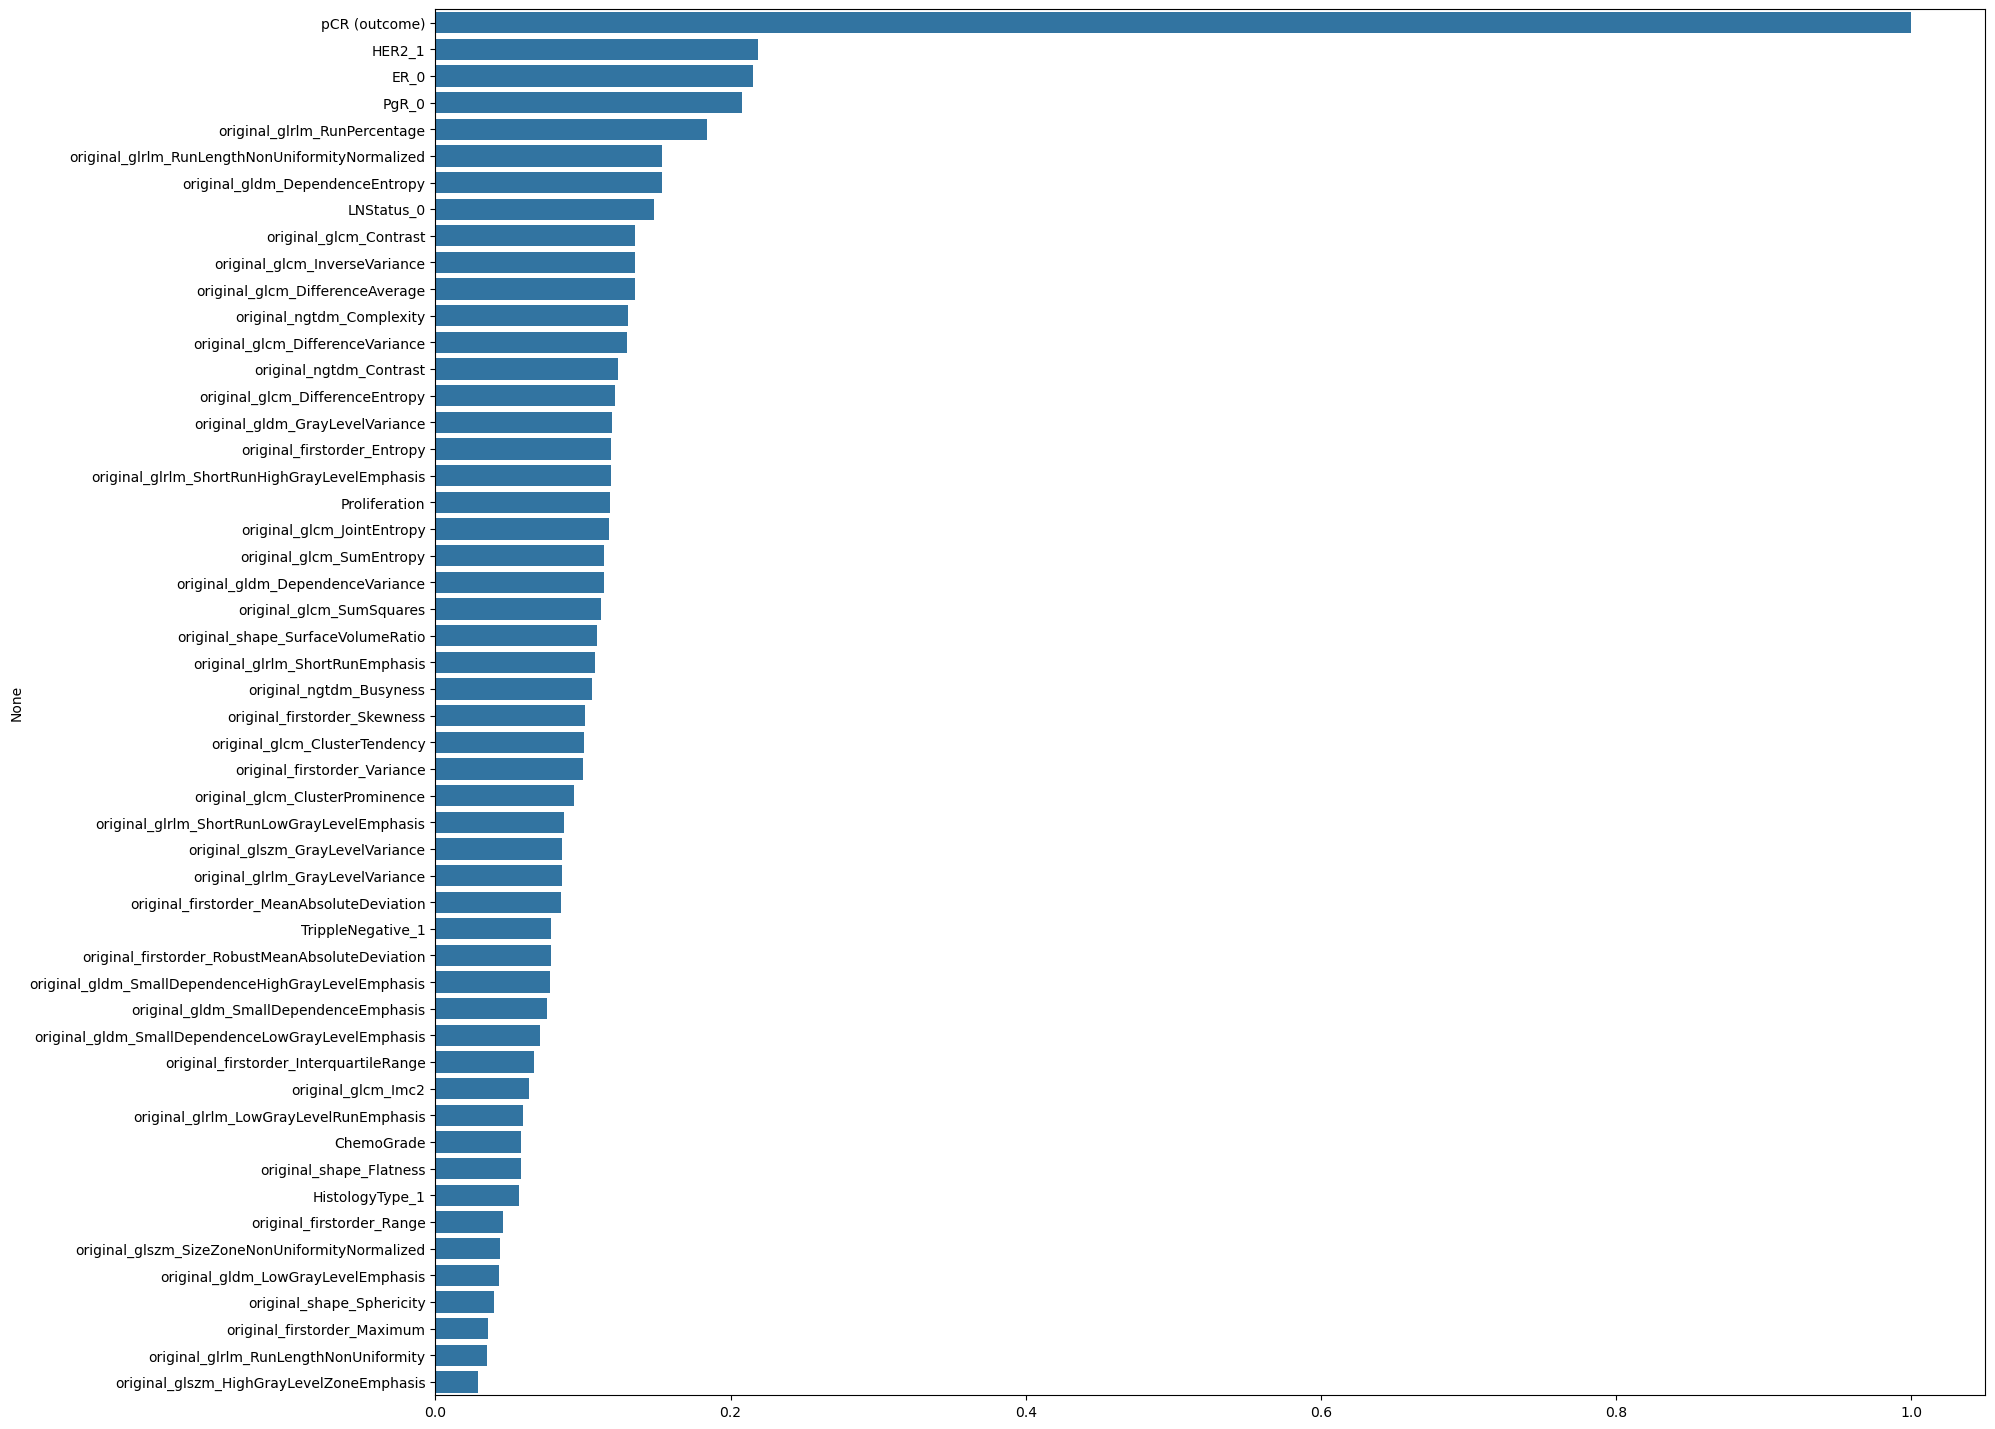

In [1364]:
# target = ['pCR (outcome)', 'RelapseFreeSurvival (outcome)' ]
target = ['pCR (outcome)']

high_corr_lst = []
for idx in range(len(target)):
    if idx == 0:
        df = pd.concat([df, pCR_label],axis=1)
    else:
        df = pd.concat([df, RelapseFreeSurvival_label], axis=1)
    corr_matrix = df.corr()
    
    threshold = 0.02

    col = corr_matrix[target[idx]] >= threshold
    high_corr_columns = corr_matrix.columns[col]
    high_corr_lst.append(high_corr_columns)

    high_corr_matrix = df[high_corr_columns].corr()
    # print(high_corr_matrix)
    order = high_corr_matrix.loc[target[idx]].sort_values(ascending=False).index

    plt.figure(figsize=(20, 18))
    sns.barplot(x=high_corr_matrix.loc[target[idx]].loc[order].values, y=order)
    plt.show()


In [1365]:
len(high_corr_lst[0])
df_high_corr = df[high_corr_columns]

In [1366]:
# high_corr_X = df_high_corr.values
# high_corr_y = pCR_label.values

# high_corr_X =high_corr_X.astype(np.float32)  
# high_corr_y =high_corr_y.astype(np.int64)    

 Accuracy: 0.8461538461538461, Precision: 1.0, Recall: 0.2, F1 Score: <function f1_score at 0x170dcf1a0>
 Accuracy: 0.782051282051282, Precision: 1.0, Recall: 0.15, F1 Score: <function f1_score at 0x170dcf1a0>
 Accuracy: 0.8205128205128205, Precision: 1.0, Recall: 0.17647058823529413, F1 Score: <function f1_score at 0x170dcf1a0>
 Accuracy: 0.8205128205128205, Precision: 0.0, Recall: 0.0, F1 Score: <function f1_score at 0x170dcf1a0>
 Accuracy: 0.7948717948717948, Precision: 0.0, Recall: 0.0, F1 Score: <function f1_score at 0x170dcf1a0>


/Users/iamyoungjin/opt/anaconda3/envs/MLproject1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/iamyoungjin/opt/anaconda3/envs/MLproject1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


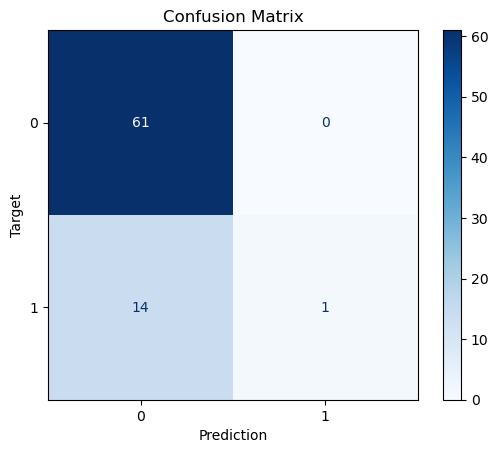

AVG Acc: 0.8128205128205128
AVG Precision: 0.6
AVG Recall: 0.10529411764705883
AVG F1 Score: 0.17884057971014494


In [1367]:
high_corr_X = df_high_corr.values
high_corr_y = pCR_label.values

high_corr_X =high_corr_X.astype(np.float32)  
high_corr_y =high_corr_y.astype(np.int64) 

KFold = KFold(n_splits=5, shuffle=True, random_state=42)

epochs = 60
lr = 0.001
input_shape = high_corr_X.shape[1]
criterion = nn.CrossEntropyLoss()

acc_lst = []
precision_lst = []
recall_lst = []
f1_score_lst = []
confusion_matrice = []  

for train_idx, test_idx in kf.split(high_corr_X):
    X_train, X_test =high_corr_X[train_idx], high_corr_X[test_idx]
    y_train, y_test =high_corr_y[train_idx], high_corr_y[test_idx]

    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)


    model = MLP2(input_shape)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()
        outputs = model(X_test_tensor)
        predicted = torch.argmax(outputs, dim=1)

        acc = accuracy_score(y_test_tensor, predicted)
        precision = precision_score(y_test_tensor, predicted)
        recall = recall_score(y_test_tensor, predicted)
        f1 = f1_score(y_test_tensor, predicted)
        cm = confusion_matrix(y_test_tensor, predicted)

        acc_lst.append(acc)
        precision_lst.append(precision)
        recall_lst.append(recall)
        f1_score_lst.append(f1)
        confusion_matrice.append(cm)

        print(f' Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}')


avg_confusion_matrix = np.mean(confusion_matrice, axis=0).astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix=avg_confusion_matrix, display_labels=np.unique(high_corr_y))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()

print(f'AVG Acc: {np.mean(acc_lst)}')
print(f'AVG Precision: {np.mean(precision_lst)}')
print(f'AVG Recall: {np.mean(recall_lst)}')
print(f'AVG F1 Score: {np.mean(f1_score_lst)}')


In [1368]:
X_resampled, y_resampled = RandomOverSampler().fit_resample(high_corr_X, high_corr_y)

In [1369]:
print(high_corr_X.shape)
print(high_corr_y.shape)
print(X_resampled.shape)
print(y_resampled.shape)

(390, 52)
(390,)
(616, 52)
(616,)


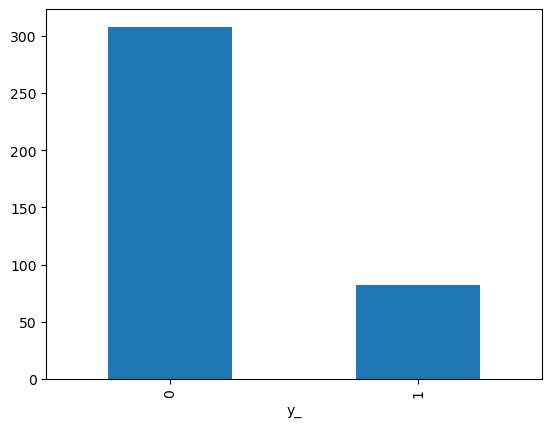

In [1370]:
df1 = pd.DataFrame({
    'y_': high_corr_y,  
})
df1['y_'].value_counts().plot(kind='bar')
plt.show()

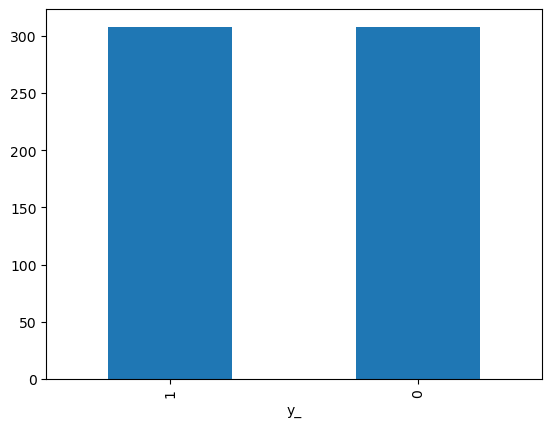

In [1371]:
df1 = pd.DataFrame({
    'y_': y_resampled,  
})
df1['y_'].value_counts().plot(kind='bar')
plt.show()

train_loss:0.6962985992431641
train_loss:0.6924006342887878
train_loss:0.690518856048584
train_loss:0.6882825493812561
train_loss:0.6865161657333374
train_loss:0.6846218705177307
train_loss:0.6823157072067261
train_loss:0.6790885329246521
train_loss:0.6767207384109497
train_loss:0.6738026142120361
train_loss:0.6732358336448669
train_loss:0.670381486415863
train_loss:0.6653789281845093
train_loss:0.6621359586715698
train_loss:0.6568587422370911
train_loss:0.65952467918396
train_loss:0.6547110080718994
train_loss:0.6469030976295471
train_loss:0.6432945728302002
train_loss:0.6418882012367249
train_loss:0.632683277130127
train_loss:0.6255009770393372
train_loss:0.623676061630249
train_loss:0.6227344870567322
train_loss:0.6163011789321899
train_loss:0.6121734380722046
train_loss:0.6054947376251221
train_loss:0.599565327167511
train_loss:0.5999982357025146
train_loss:0.5876309871673584
train_loss:0.5762757062911987
train_loss:0.569945216178894
train_loss:0.5636770129203796
train_loss:0.55370

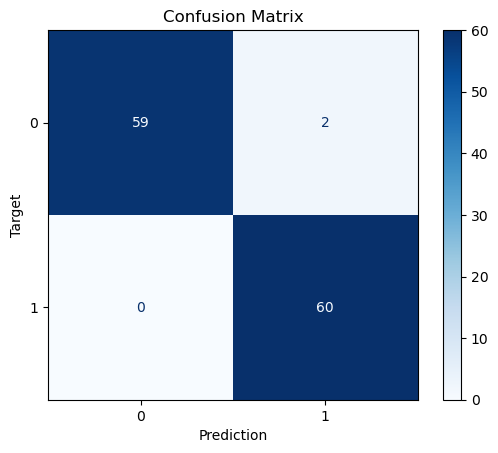

AVG Acc: 0.9756753212693419
AVG Precision: 0.9634223984970254
AVG Recall: 0.9862972620599739
AVG F1 Score: 0.9746398506054336


In [1372]:
from sklearn.model_selection import KFold
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

epochs = 60
lr = 0.001
input_shape = X_resampled.shape[1]


epochs = 60
lr = 0.001
input_shape = high_corr_X.shape[1]
criterion = nn.CrossEntropyLoss()


acc_lst = []
precision_lst = []
recall_lst = []
f1_score_lst = []
confusion_matrice = [] 


for train_idx, test_idx in kf.split(X_resampled):
    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
    
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)

    model = MLP2(input_shape)
    # optimizer = optim.Adam(model.parameters(), lr=lr) 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01) 

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        print(f'train_loss:{loss}')

    with torch.no_grad():
        model.eval()
        val_loss = 0

        outputs = model(X_test_tensor)
        predicted = torch.argmax(outputs, dim=1)
        validation_outputs = model(X_test_tensor)
        val_losses = criterion(validation_outputs, y_test_tensor)
        print(f'val_losses:{val_losses}')        
        
        acc = accuracy_score(y_test_tensor, predicted)
        precision = precision_score(y_test_tensor, predicted)
        recall = recall_score(y_test_tensor, predicted)
        f1 = f1_score(y_test_tensor, predicted)
        cm = confusion_matrix(y_test_tensor, predicted)

        acc_lst.append(acc)
        precision_lst.append(precision)
        recall_lst.append(recall)
        f1_score_lst.append(f1)
        confusion_matrice.append(cm)

        print(f' Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}')

avg_confusion_matrix = np.mean(confusion_matrice, axis=0).astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix=avg_confusion_matrix, display_labels=np.unique(y_resampled))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()

print(f'AVG Acc: {np.mean(acc_lst)}')
print(f'AVG Precision: {np.mean(precision_lst)}')
print(f'AVG Recall: {np.mean(recall_lst)}')
print(f'AVG F1 Score: {np.mean(f1_score_lst)}')

